# Example: Load and visualize SynthMT dataset

This example demonstrates how to load the SynthMT dataset using the `datasets` library, decompose a sample into its image and masks, and visualize the masks overlaid on the image.

## Dataset Overview

The **SynthMT** dataset contains synthetic microscopy images of microtubules (MTs) with corresponding instance segmentation masks. The data simulates **Interference Reflection Microscopy (IRM)** conditions where:

- **Background** appears bright (high intensity) due to reflection from the glass substrate
- **Microtubules** appear dark (low intensity) due to destructive interference
- **Seeds** (GMPCPP-stabilized) are marked with a red stain

Each sample provides:
- `image`: RGB microscopy image (PIL Image)
- `mask`: List of binary masks, one per microtubule instance (List of PIL Images)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datasets import load_dataset
from synth_mt.plotting import create_overlay

## Load SynthMT Dataset

We use the HuggingFace `datasets` library to load SynthMT from the Hub.

**Key points:**
- First download may take a few minutes (dataset is cached for subsequent loads)
- Set `cache_dir` parameter to specify a custom cache location
- The dataset has a single "train" split containing all samples

**Dataset location:** `HTW-KI-Werkstatt/SynthMT`

In [2]:
# Load the SynthMT dataset
ds = load_dataset("HTW-KI-Werkstatt/SynthMT", split="train", cache_dir=None)

In [3]:
print(f"SynthMT dataset contains {len(ds)} samples.")

SynthMT dataset contains 6600 samples.


## Decompose a Sample

Each sample in the dataset is a dictionary with two keys:

| Key | Type | Description |
|-----|------|-------------|
| `image` | `PIL.Image` | RGB microscopy image |
| `mask` | `List[PIL.Image]` | List of binary masks (one per MT instance) |

### Why a List of Masks?

Unlike semantic segmentation (where each pixel has one class label), **instance segmentation** requires distinguishing individual objects of the same class.

Storing masks as a list allows:
- **Overlapping instances**: MTs can cross each other without label conflicts
- **Flexible number of instances**: Each image can have a different number of MTs

In [4]:
# Take a sample and decompose it
sample_idx = 0
sample = ds[sample_idx]

image: Image.Image = sample["image"]
masks: list[Image.Image] = sample["mask"]

print(f"Sample {sample_idx}:")
print(f"  - Image size: {image.size}")
print(f"  - Number of masks: {len(masks)}")

Sample 0:
  - Image size: (512, 512)
  - Number of masks: 6


## How to convert to NumPy

For most machine learning frameworks, you'll need to convert PIL Images to NumPy arrays:

### Image Conversion

```python
img_array = np.array(image.convert("RGB"))  # Shape: (H, W, 3)
```

### Mask Stack Conversion
The list of binary masks is stacked into a 3D array:

```python
mask_stack = np.stack([...], axis=0)  # Shape: (N, H, W)
```

where `N` is the number of instances.

**Note:** Each mask is converted to grayscale ("L" mode) with values 0 (background) or 255 (foreground).

In [5]:
# Image as numpy array (H, W, 3)
img_array = np.array(image.convert("RGB"))

# Masks as stacked numpy array (N, H, W) where N is the number of instances
mask_stack = np.stack([np.array(mask.convert("L")) for mask in masks], axis=0)

print("Image shape:", img_array.shape)
print("Mask stack shape:", mask_stack.shape)

Image shape: (512, 512, 3)
Mask stack shape: (6, 512, 512)


## How to convert instance stack (N, H, W) to 2D mask (H, W)

Some methods require a single 2D label map instead of stacked binary masks:

$$M_{2D}(x, y) = \begin{cases}
0 & \text{if background} \\
i & \text{if pixel belongs to instance } i
\end{cases}$$

### Conversion Process
```python
for label in range(N):
    mask_2d[mask_stack[label] > 0] = label + 1
```

### ⚠️ Important Caveat
This conversion loses information at intersections! When two MTs cross:
- In the stacked format: both masks have value > 0 at the intersection
- In the 2D format: only the last-written label is preserved

For precise instance segmentation, prefer the stacked mask format.


In [6]:
# Convert instance stack to 2D mask
mask_2d = np.zeros(masks[0].size, dtype=np.uint8)
for label in range(mask_stack.shape[0]):
    mask_2d[mask_stack[label] > 0] = label + 1

print("Mask shape:", mask_2d.shape)
print("Mask unique values:", np.unique(mask_2d))

Mask shape: (512, 512)
Mask unique values: [0 1 2 3 4 5 6]


## Visualize some samples with the overlay

The `create_overlay` function from `examples.utils` combines the image and masks into a single visualization where each instance is shown in a different color.

This helps verify:
- Mask alignment with visible structures
- Instance separation quality
- Coverage of all MTs in the image

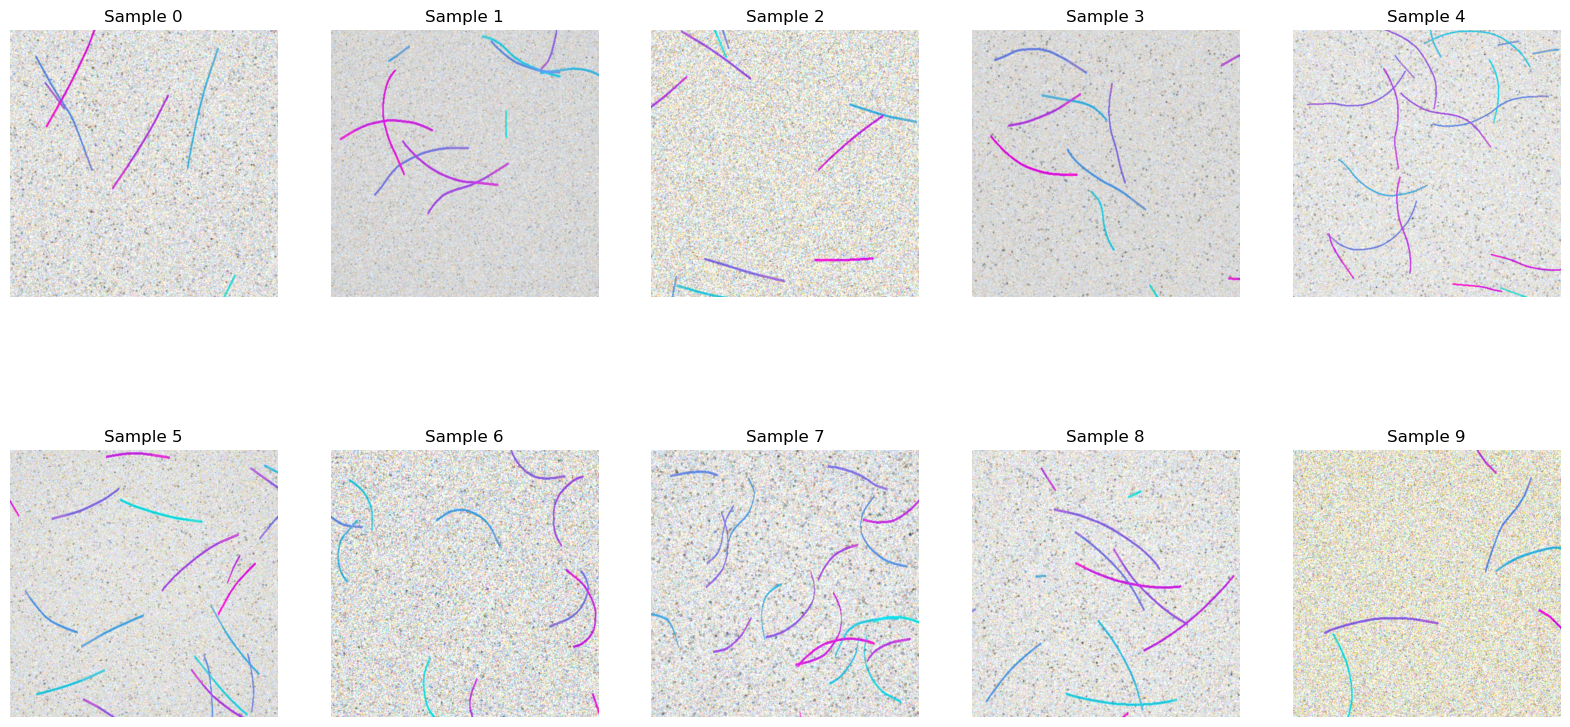

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for ax, idx in zip(axs, range(len(ds))):
    sample = ds[idx]
    overlay = create_overlay(sample["image"], sample["mask"])

    ax.imshow(overlay)
    ax.axis("off")
    ax.set_title(f"Sample {idx}")